In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy

In [2]:
data = pd.read_csv('../data/Close_correct.csv', index_col='date')
data.index = data.index.astype('datetime64').rename('date')
data.head()

,0,1,2,3,4,5,6,7,8,9,...,2426,2427,2428,2429,2430,2431,2432,2433,2434,2435
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,20.225,22.355,9.3094,10.20,3.4959,9.955,26.66,11.898,9.4832,16.594,...,2.9896,21.90,19.270,12.832,17.76,7.7942,33.864,18.690,303.66,12.231
2010-01-05,20.858,22.589,9.1551,10.25,3.4577,10.022,26.57,11.954,9.5110,16.765,...,3.0673,20.91,19.466,13.234,17.88,7.8400,34.744,18.780,301.20,12.305
2010-01-06,20.612,22.637,9.0008,10.05,3.3339,10.217,26.92,11.594,9.5150,16.779,...,3.0390,20.80,19.570,13.442,16.68,7.8477,35.070,18.890,302.01,12.395
2010-01-07,20.683,22.269,9.0205,10.40,3.5341,10.115,26.50,11.695,9.7720,16.454,...,3.2582,21.65,19.613,13.120,17.52,7.8707,34.599,19.175,292.72,12.345
2010-01-08,21.085,22.192,8.9584,11.35,3.4197,10.149,26.19,11.485,9.8060,16.779,...,3.2016,21.25,19.570,13.106,17.52,7.8785,34.813,19.474,296.55,12.435


In [3]:
data_returns = pd.read_csv('../data/data_returns.csv', index_col='date')
data_returns.index = data_returns.index.astype('datetime64').rename('date')
data_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,2426,2427,2428,2429,2430,2431,2432,2433,2434,2435
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.031298,0.010467,-0.016575,0.004902,-0.010927,0.006730,-0.003376,0.004707,0.002931,0.010305,...,0.025990,-0.045205,0.010171,0.031328,0.006757,0.005876,0.025986,0.004815,-0.008101,0.006050
2010-01-06,-0.011794,0.002125,-0.016854,-0.019512,-0.035804,0.019457,0.013173,-0.030115,0.000421,0.000835,...,-0.009226,-0.005261,0.005343,0.015717,-0.067114,0.000982,0.009383,0.005857,0.002689,0.007314
2010-01-07,0.003445,-0.016257,0.002189,0.034826,0.060050,-0.009983,-0.015602,0.008711,0.027010,-0.019369,...,0.072129,0.040865,0.002197,-0.023955,0.050360,0.002931,-0.013430,0.015087,-0.030761,-0.004034
2010-01-08,0.019436,-0.003458,-0.006884,0.091346,-0.032370,0.003361,-0.011698,-0.017956,0.003479,0.019752,...,-0.017372,-0.018476,-0.002192,-0.001067,0.000000,0.000991,0.006185,0.015593,0.013084,0.007290


In [4]:
# numpy
def neutralize(alpha):
    return alpha - np.mean(alpha)

In [5]:
def normalize(alpha):
    return alpha / np.sum(np.abs(alpha))

In [6]:
def truncate(alpha, max_weight, coef):
    signs = (alpha / np.abs(alpha))
    alpha[np.abs(alpha) > max_weight * coef] = max_weight * coef
    alpha = alpha * signs
    return alpha

In [7]:
# pandas
def get_returns(data):
    return (data / data.shift(1))

In [8]:
def ranking(alpha):
    alpha = scipy.stats.rankdata(alpha, method='ordinal') / (len(alpha) - 1)
    return alpha

In [9]:
def cut_outliers(alpha, coef):
    alpha[alpha < np.quantile(alpha, coef)] = 0
    alpha[alpha > np.quantile(alpha, 1 - coef)] = 0
    return alpha

In [10]:
def cut_middle(alpha, eps):
    alpha[(alpha <= np.mean(alpha) + eps) & (alpha >= np.mean(alpha) - eps)] = 0
    return alpha

In [11]:
def turnover(alphas, option=0):
    turnover_days = abs(alphas.diff(periods=1)).sum(axis=1)
    if option == 1:
        return turnover_days
    return turnover_days.groupby(alphas.index.year).mean()

In [12]:
def get_pnl(returns, alpha, option=0):
    pnl = alpha.reset_index(drop=True).mul(returns.reset_index(drop=True), axis=0).sum(axis=1)
    ans = pd.DataFrame()
    ans['pnl'] = pnl
    ans = ans.set_index(alpha.index).shift(1)
    if option == 1:
        return ans.set_index(alpha.index).groupby(alpha.index.year).sum()
    return ans

##### Alpha: reversion
$$ alpha = {close(d - n) \over close(d - 1)} - 1$$


In [13]:
def algh_alpha_reversion_2(data, n):
    alpha = -(data / data.shift(n) - 1)
    alpha = alpha.T.apply(neutralize).apply(normalize).T
    return alpha

In [14]:
alpha_revers = algh_alpha_reversion_2(data, 1)
years_pnl_cum = get_pnl(data_returns.iloc[1:], alpha_revers, 1)
days_pnl = get_pnl(data_returns.iloc[1:], alpha_revers)

print('years pnl cum:', '\n', years_pnl_cum)

years pnl cum: 
            pnl
date          
2010  0.280124
2011  0.357814
2012  0.172696
2013  0.108339
2014  0.071072


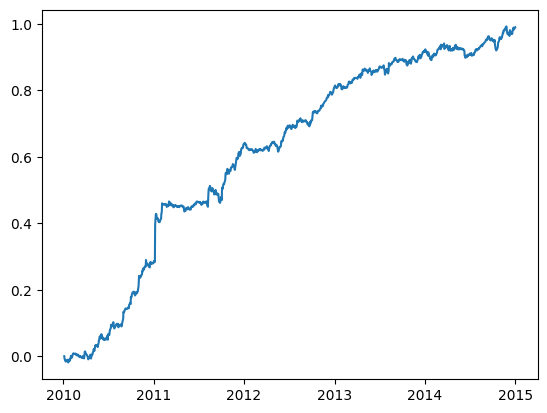

In [15]:
plt.plot(days_pnl.cumsum())

test  
There seems to be a bias or some other error.  
Let's check that the program works correctly for the first day, when return is known.

In [16]:
print('returns 2010-01-06 day:', '\n', data_returns.iloc[2])
print('======================================================')
print('alpha 2010-01-05 day:', alpha_revers.iloc[1])
print('======================================================')
print('pnl 2010-01-06 day:', '\n', sum(data_returns.iloc[2] * alpha_revers.iloc[1]))
print('and')
print(days_pnl.iloc[2])

returns 2010-01-06 day: 
 0      -0.011794
1       0.002125
2      -0.016854
3      -0.019512
4      -0.035804
          ...   
2431    0.000982
2432    0.009383
2433    0.005857
2434    0.002689
2435    0.007314
Name: 2010-01-06 00:00:00, Length: 2436, dtype: float64
alpha 2010-01-05 day: 0      -0.000628
1      -0.000176
2       0.000411
3      -0.000055
4       0.000289
          ...   
2431   -0.000076
2432   -0.000513
2433   -0.000053
2434    0.000227
2435   -0.000080
Name: 2010-01-05 00:00:00, Length: 2436, dtype: float64
pnl 2010-01-06 day: 
 -0.007094632221149888
and
pnl   -0.007095
Name: 2010-01-06 00:00:00, dtype: float64
